In [1]:
# -*- coding: utf-8 -*-
#CUDA_VISIBLE_DEVICES=0
import os
import pandas as pd
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import scipy

import pybacktest as pb
import matplotlib.pyplot as plt

import threading
import multiprocessing
import tensorflow as tf
import tensorflow.contrib.slim as slim
import scipy.signal
%matplotlib inline
from random import choice
from time import sleep
from time import time
import sys
from trader_gym import environment
from A3C_class import *
import mpld3
mpld3.enable_notebook()
# %load_ext ipycache
max_episode_length = 300


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# !pip install git+https://github.com/ematvey/pybacktest.git
# !pip install pandas_datareader
# from pandas.api.types import is_list_like
# !pip install mpld3

In [3]:
# plt.plot([prices[max(0,i-5000):i].mean() for i in range(1,prices.shape[0])])
# plt.plot([prices[-50000:].mean()for i in range(1,prices.shape[0])])
# plt.legend(['past_mean', 'mean'])
# plt.show()
# plt.plot([prices[max(0,i-5000):i].min() for i in range(1,prices.shape[0])])
# plt.plot([prices[-50000:].min()for i in range(1,prices.shape[0])])
# plt.legend(['past_min', 'min'])
# plt.show()
# plt.plot([prices[max(0,i-5000):i].max() for i in range(1,prices.shape[0])])
# plt.plot([prices[-50000:].max()for i in range(1,prices.shape[0])])
# plt.legend(['past_max', 'max'])
# plt.show()
# # plt.savefig("means.pdf")
# plt.plot([pd.rolling_min(prices, 1000) for i in range(1,prices.shape[0])])
# plt.plot([prices[-5000:].max()for i in range(1,prices.shape[0])])
# plt.legend(['past_max', 'max'])
# # plt.savefig("maxs.pdf")
# plt.show()
# plt.plot([pd.rolling_max(prices, 1000) for i in range(1,prices.shape[0])])
# plt.plot([prices[-5000:].min()for i in range(1,prices.shape[0])])
# plt.legend(['past_min', 'min'])
# # plt.savefig("mins.pdf")
# plt.show()

In [4]:
data_dir_path = '/mnt/a3c_data/'

In [5]:
from google_drive_downloader import GoogleDriveDownloader as gdd  
    
gdd.download_file_from_google_drive(file_id='0B0ozwxwZOzYLRHpWSktjWmVfdHM',
                                    dest_path=data_dir_path+"['RTS-12.15']",
                                    unzip=False)
gdd.download_file_from_google_drive(file_id='0B0ozwxwZOzYLcjNWUHV1NFdXRE0',
                                    dest_path=data_dir_path+"['RTS-3.16']",
                                    unzip=False)
gdd.download_file_from_google_drive(file_id='0B0ozwxwZOzYLVVhQUkpfS0VCWUk',
                                    dest_path=data_dir_path+"['RTS-6.16']",
                                    unzip=False)
gdd.download_file_from_google_drive(file_id='0B0ozwxwZOzYLSDM1VWxwRTZQN1E',
                                    dest_path=data_dir_path+"['RTS-9.16']",
                                    unzip=False)
gdd.download_file_from_google_drive(file_id='0B0ozwxwZOzYLWV9PRXplcmZBVHM',
                                    dest_path=data_dir_path+"['RTS-12.15', 'RTS-3.16']",
                                    unzip=False)
gdd.download_file_from_google_drive(file_id='0B0ozwxwZOzYLQl9qeV9ZN28yWGM',
                                    dest_path=data_dir_path+"['RTS-9.15', 'RTS-12.15', 'RTS-3.16']",
                                    unzip=False)

In [7]:
postfix = ['RTS-9.15', 'RTS-12.15', 'RTS-3.16']
R = pd.read_pickle(data_dir_path+str(postfix))
start_pt = R.index.get_loc('2015-12-15 10:00:00')[0]
print(start_pt, R.ix[:,:].shape[0])

105027 149170


# RUNNIN MEAN FOR 5K

In [10]:
postfix_to_save = ['RTS-3.16', 'RTS-6.16']
# dd = R.values
# Rs = pd.DataFrame(data=dd[start_pt:], index = R.index[start_pt:], columns = R.columns)
# print(Rs.head(2))
len = R.ix[:,:].shape[0]
%time Rmax = np.array([R.ix[max(0,i-5000):max(1,i),:].max() for i in range(len)])
%time Rmin = np.array([R.ix[max(0,i-5000):max(1,i),:].min() for i in range(len)])
%time Rmean = np.array([R.ix[max(0,i-5000):max(1,i),:].mean() for i in range(len)])

dd = (R.values - Rmean)/(Rmax - Rmin)
Rs = pd.DataFrame(data=dd[start_pt:], index = R.index[start_pt:], columns = R.columns)

Rs.to_pickle(data_dir_path+str(postfix_to_save)+'w5k')
import pickle
def change_pickle_protocol(filepath,protocol=2):
    with open(filepath,'rb') as f:
        obj = pickle.load(f)
    with open(filepath,'wb') as f:
        pickle.dump(obj,f,protocol=protocol)
change_pickle_protocol(data_dir_path+str(postfix_to_save)+'w5k')

# for i in range(37):
#     plt.plot(Rmax[:,i])
#     plt.plot(Rmin[:,i])
#     plt.plot(Rmean[:,i])
#     plt.legend(['max', 'min', 'mean'])
#     plt.title('Max|Min|Mean, window=5000, feature={}'.format(i))
#     plt.savefig('MMM_window=5000_feature={}.pdf'.format(i))

CPU times: user 4min 13s, sys: 520 ms, total: 4min 13s
Wall time: 4min 13s
CPU times: user 4min 13s, sys: 408 ms, total: 4min 13s
Wall time: 4min 13s
CPU times: user 4min, sys: 408 ms, total: 4min
Wall time: 4min


In [12]:
# data
postfix = ['RTS-3.16', 'RTS-6.16']
R = pd.read_pickle(data_dir_path+str(postfix))
test_R = R.copy()
# print (R.mean()[0], R.max()[0], (R.max()[0] - R.min()[0]), (R.max()[0] - R.mean()[0])/(R.max()[0] - R.min()[0]), (R.min()[0] - R.mean()[0])/(R.max()[0] - R.min()[0]))
R = (R - R.mean()) / (R.max() - R.min())
old_R = R.copy()
vals = R.values
D = np.hstack([vals[i:-dep+i-1, :] for i in range(dep,0,-1)])
R = pd.DataFrame(D, R[dep:-1].index)
# R = R[:10000]

In [13]:
# Main
def run_trades(max_episode_length, gamma, s_size, a_size, load_model, model_path, length, env):
    tf.reset_default_graph()
    with tf.device('/gpu:0'): 
        global_episodes = tf.Variable(0,dtype=tf.int32,name='global_episodes',trainable=False)
        trainer = tf.train.RMSPropOptimizer(learning_rate = 1e-3, decay = 0.99, epsilon = 1e-6)
        master_network = AC_Network(s_size,a_size,'global',None)
        num_workers = 1
        workers = []
        for i in range(num_workers):
            workers.append(Test_Worker(env,i,s_size,a_size,trainer,model_path,global_episodes))
        saver = tf.train.Saver(max_to_keep=5)

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0)
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=False, log_device_placement=False, gpu_options=gpu_options)) as sess:   
        coord = tf.train.Coordinator()

        if load_model == True:
            print ('Loading Model...')
            ckpt = tf.train.get_checkpoint_state(model_path)
            saver.restore(sess,ckpt.model_checkpoint_path)
        else:
            sess.run(tf.global_variables_initializer())

        summary_writer = tf.summary.FileWriter('tb/train', graph=sess.graph)
        worker_threads = []
        for worker in workers:
            worker_work = lambda: worker.work(max_episode_length,gamma,sess,coord,saver,dep, 0.33)
            t = threading.Thread(target=(worker_work))
            t.start()
            worker_threads.append(t)

        coord.join(worker_threads)
        acts = workers[0].acts
        rews = workers[0].rewards
    return acts, rews

In [14]:
## Торговая система - покупаем/продаем в зависимости от предсказанного класса
def backtest(acts, o_R):
    pacts = np.asarray(acts).copy()
    for i in range(1,pacts.shape[0]):
        if pacts[i] == 0:
            if pacts[i-1] == -1:
                #from short
                pacts[i] = 0.5
            elif pacts[i-1] == 1:
                pacts[i] = -0.5

    # plt.plot(pacts, '.')
    data = o_R[dep-1:-3]

    buy= cover = pd.Series(pacts == 1, index=data.index)
    short = sell= pd.Series(pacts == -1, index=data.index)
    cover = pd.Series(pacts > 0, index=data.index)
    sell = pd.Series(pacts < 0, index=data.index)
    # print(np.sum(buy-sell))
    OHLC = data[[('DealPrice', 'close'), ('DealPrice', 'close'), ('DealPrice', 'close'), ('DealPrice', 'close')]]
    OHLC.columns = ['O', 'H', 'L', 'C']
    # Основной график эквити
    bt = pb.Backtest(locals())
    return bt

In [16]:

load_model = False
model_path = 'model'
length = R.shape[0]
noise_level = 1e-5
price = R.values[:,3]
n_noises = 1
n_runs = 4

test_acts = np.zeros((n_noises, n_runs, length-1))
test_rews = np.zeros((n_noises, n_runs, length-1))

for j in range(n_noises):
    np.random.seed(j)
    env = environment(R+(np.random.rand(R.shape[0],R.shape[1])-0.5)*(1e-5*(0**j)), length)
    for i in range(n_runs):
        np.random.seed(i+1377)
        test_acts[j,i,:], test_rews[j,i,:] = run_trades(max_episode_length, gamma, s_size, a_size, load_model, model_path, length, env)
        print(j,i)
    

Starting worker 0
92582 -337.6272561101092
0 0
Starting worker 0
92582 -3235.072048217807
0 1
Starting worker 0
92582 -448.5385429603152
0 2
Starting worker 0
92582 -16951.261947320058
0 3


In [17]:
## ПРИ НЕУВЕРЕННОСТИ НУЖНО ДЕЛАТЬ ПРЕДЫДУЩЕЕ ДЕЙСТВИЕ, А НЕ 0

test_acts_probs = np.zeros((n_noises, a_size, length-1))
tresh = 0.0
acts = np.zeros((n_noises, length-1))
test_acts = test_acts.astype(int)
for k in range(n_noises):
    for j in range(n_runs):
        for i in range(length-1):
            a = test_acts[k,j,i]
            test_acts_probs[k,a+1,i] += 1
    test_acts_probs[k,:,:] = test_acts_probs[k,:,:]/n_runs
    acts[k,:] = [np.argmax(x)-1 if max(x) > tresh else 0 for x in test_acts_probs[k,:,:].T]
# print(test_acts_probs)
# plt.plot(acts.T)
# plt.show()

AttributeError: 'DatetimeIndex' object has no attribute 'to_datetime'

<Figure size 864x720 with 0 Axes>

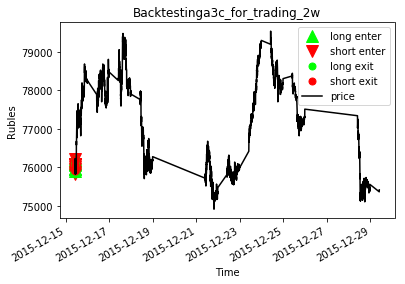

In [19]:
def write_report(r, filename):    
    with open(filename, "a") as input_file:
        for k, v in r.items():
            line = '{}, {}'.format(k, v) 
            print(line, file=input_file)
            
folder = os.path.relpath(".","..")
for i in range(4):    
    lengths = [ R.index.get_loc('2015-12-29 10:06:00')[0], R.index.get_loc('2016-01-15 10:06:00')[0], \
                    R.index.get_loc('2016-03-15 10:06:00')[0], R.index.get_loc('2016-06-15 10:06:00')[0] ]
    names = ['2w', '1m', '3m', '6m']
    bt = backtest(acts[-1,:lengths[i]], test_R[:lengths[i]+dep+2])
    fig = plt.figure(figsize=(12, 10))
    bt.plot_trades()
    plt.legend(loc='best')
    plt.title('Backtesting'+folder+'_'+names[i])
    plt.ylabel('Rubles')
    plt.xlabel('Time')        
    plt.plot()
    # plt.show()
    plt.savefig(data_dir_path+'plots/'+folder+'_'+names[i]+'.png', bbox_inches='tight')

    # Отчет по системе
    B = bt.report
    write_report(B, data_dir_path+'plots/'+folder+'_.txt')

In [ ]:
# # Зависимость от доли выборщиков
# for tresh in np.arange(0,1,0.1):
#     acts[-1,:] = [np.argmax(x)-1 if max(x) > tresh else 0 for x in test_acts_probs[-1,:,:].T]
#     bt = backtest(acts[-1,:], old_R)
#     B = bt.report
#     profit = B['performance']['profit']
#     print tresh, profit

In [20]:
tresh = 0.0
for k in range(n_noises):
    acts[k,:] = [np.argmax(x)-1 if max(x) > tresh else 0 for x in test_acts_probs[k,:,:].T]
    bt = backtest(acts[k,:], old_R)
    B = bt.report
    profit = B['performance']['profit']
    print profit

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-20-8b0c4d719d2b>, line 7)